In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rosbag
from tqdm import tqdm
import glob, os

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

width = 3.487
height = width / 1.618

%run ./scripts/util_func.py
%run ./scripts/model_func.py

def to_time(timestamp):
    return timestamp.secs + 1e-9*timestamp.nsecs

dataset_path = "/media/dominic/462D-1EE8/rosbags/doughnut_calibs/husky/day1/doughnut/extracted_data/" #doughnut_1_data.csv
os.chdir(dataset_path)
files = list(glob.glob("*.csv"))

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [4]:
# import data to dataframe
# Data rate is 20 HZ

dataframe = pd.read_csv(dataset_path + files[1])
dataframe = dataframe.drop([0, 1, 2])

print(dataframe)

       Unnamed: 0      ros_time joy_switch  icp_index good_calib_step  \
3               3  1.659706e+18      False        0.0           False   
4               4  1.659706e+18      False        0.0           False   
5               5  1.659706e+18      False        0.0           False   
6               6  1.659706e+18      False        0.0           False   
7               7  1.659706e+18      False        0.0           False   
...           ...           ...        ...        ...             ...   
47292       47292  1.659709e+18      False    23117.0            True   
47293       47293  1.659709e+18      False    23118.0            True   
47294       47294  1.659709e+18      False    23118.0            True   
47295       47295  1.659709e+18      False    23119.0            True   
47296       47296  1.659709e+18      False    23119.0            True   

       wheel_pos_left  wheel_pos_right  cmd_vel_x  cmd_vel_y  icp_pos_x  \
3            0.000000         0.000000        0.

/tmp/ipykernel_7340/3075724598.py:4: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(dataset_path + files[1])


In [5]:
# extract values from dataset

# choose which run to analyse
run = dataframe

timestamp = run['ros_time'].to_numpy()
timestamp = (timestamp - timestamp[0]) * 10 ** (-9) # time (s)

icp_id = run['icp_index'].to_numpy()
joy = run['joy_switch'].to_numpy()
joy = joy == 'True'
good_calib_step = run['good_calib_step'].to_numpy()
good_calib_step = good_calib_step == 'True'

icp_x = run['icp_pos_x'].to_numpy() # icp x position (m)
icp_y = run['icp_pos_y'].to_numpy() # icp y position (m)

icp_quat_x = run['icp_quat_x'].to_numpy()
icp_quat_y = run['icp_quat_y'].to_numpy()
icp_quat_z = run['icp_quat_z'].to_numpy()
icp_quat_w = run['icp_quat_w'].to_numpy()

wheel_pos_left = run['wheel_pos_left'].to_numpy()
wheel_pos_right = run['wheel_pos_right'].to_numpy()

cmd_vx = run['cmd_vel_x'].to_numpy()
cmd_omega = run['cmd_vel_y'].to_numpy()

n_points = timestamp.shape[0]

icp_roll = np.zeros(n_points)
icp_pitch = np.zeros(n_points)
icp_yaw = np.zeros(n_points)

for i in range(0, n_points):
    icp_roll[i], icp_pitch[i], icp_yaw[i] = quaternion_to_euler(icp_quat_w[i], icp_quat_x[i], icp_quat_y[i], icp_quat_z[i]) # icp orientation (rad)

icp_id_arr = run['icp_index'].to_numpy()    

imu_pitch = run['imu_y'].to_numpy()
imu_roll = run['imu_x'].to_numpy()
imu_yaw = run['imu_z'].to_numpy()
imu_euler = np.column_stack((imu_roll, imu_pitch, imu_yaw))

icp_quat = np.column_stack((icp_quat_x, icp_quat_y, 
                               icp_quat_z, icp_quat_w))    

icp_euler = np.zeros((icp_quat.shape[0], 3))

for i in range(icp_quat.shape[0]):
    icp_euler[i,0], icp_euler[i,1], icp_euler[i,2] = quaternion_to_euler(icp_quat[i,3], icp_quat[i,0], icp_quat[i,1], icp_quat[i,2])

icp_states = np.column_stack((timestamp, icp_id, icp_x, icp_y, icp_euler[:,2]))

n_points = timestamp.shape[0]

print(good_calib_step)

[False False False ... False False False]


[  0.   0.   0. ... 215. 215. 215.]


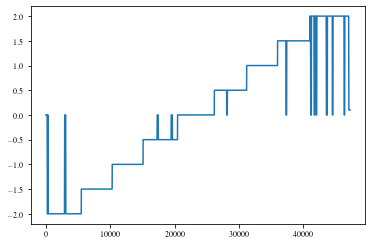

In [6]:
# create calibration step array

calib_step = np.zeros(n_points)
new_command_step = np.zeros(n_points)
prev_cmd_omega = 0
prev_cmd_vx = 0
cmd_step_id = 0
step_time = 0

for i in range(1, n_points):
    if cmd_omega[i] != prev_cmd_omega and cmd_omega[i] != 0: # catches all steps except first angular of each linear step
        cmd_step_id += 1
        prev_cmd_omega = cmd_omega[i]
        new_command_step[i] = 1
    if cmd_omega[i] == 0 and (cmd_vx[i] - cmd_vx[i-1]) == 0.5: # catches the first angular step of each linear step
        cmd_step_id += 1
        prev_cmd_omega = cmd_omega[i]
        new_command_step[i] = 1

    calib_step[i] = cmd_step_id
    
print(calib_step) ## should be 216 steps

plt.plot(cmd_vx[0:])

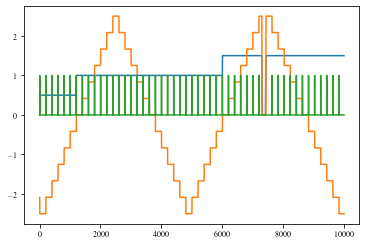

In [7]:
plt.plot(cmd_vx[30000:40000])
plt.plot(cmd_omega[30000:40000])
plt.plot(new_command_step[30000:40000])

In [9]:
def compute_speed(wheel_ticks, dt):
    wheel_speed = np.diff(wheel_ticks) / dt
    return wheel_speed

def convoluate_speed_npoints(speed, npoints):
    speed_conv = np.convolve(speed, np.ones((npoints,))/npoints, mode='same')
    return speed_conv

# def compute_wheel_speed(wheel_pos, time):
#     wheel_speed = np.zeros(wheel_pose.shape[0])
#     for i in range(1, wheel_pos.shape[0]):
        

In [10]:
# compute wheel vels
wheel_left_vel = np.zeros(n_points)
wheel_right_vel = np.zeros(n_points)

for i in range(20, n_points):
    dt = timestamp[i] - timestamp[i-1]
    if dt < 0.01:
        wheel_left_vel[i] = wheel_left_vel[i-1]
        wheel_right_vel[i] = wheel_right_vel[i-1]
    else:
        wheel_left_vel[i] = (wheel_pos_left[i] - wheel_pos_left[i-1]) / dt
        wheel_right_vel[i] = (wheel_pos_right[i] - wheel_pos_right[i-1]) / dt
        
n_points_convolution = 20
wheel_left_vel = np.convolve(wheel_left_vel, np.ones((n_points_convolution,))/n_points_convolution, mode='same')
wheel_right_vel = np.convolve(wheel_right_vel, np.ones((n_points_convolution,))/n_points_convolution, mode='same')
wheel_vels = np.vstack((wheel_left_vel, wheel_right_vel)).T
print(wheel_vels)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


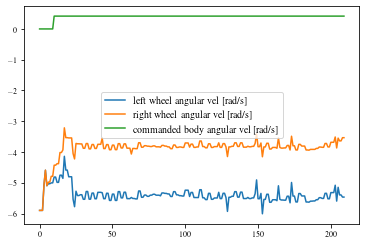

In [11]:
# plot single command step
cmd_step = 50
step_length = 210

for i in range(0, n_points):
    if calib_step[i] == cmd_step:
        plt.plot(wheel_left_vel[i-step_length:i], label='left wheel angular vel [rad/s]')
        plt.plot(wheel_right_vel[i-step_length:i], label='right wheel angular vel [rad/s]')
        plt.plot(cmd_omega[i-step_length:i], label='commanded body angular vel [rad/s]')
        plt.legend()
        break

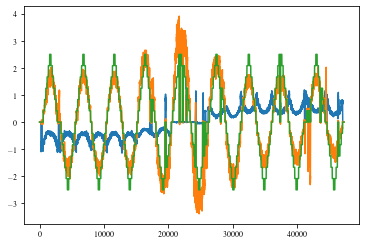

In [12]:
# compute diff drive model from encoders

# # warthog
# r = 0.3 # wheel radius (m)
# B = 1.296 # wheel base (m)
# A = 1.52 - r*2
# m = 260
# g = 9.8

# husky
r = 0.33/2 # wheel radius (m)
B = 0.55 # wheel base (m)
m = 50
g = 9.8

k = np.array([r, B])

diff_drive_vels = np.zeros((n_points, 3))

for i in range(0, n_points):
    diff_drive_vels[i, :] = diff_drive(wheel_vels[i, :],  k)
    
plt.plot(diff_drive_vels[:, 0])
plt.plot(diff_drive_vels[:, 2])
plt.plot(cmd_omega)

In [13]:
# compute icp-based velocity

icp_vx = np.zeros(n_points)
imu_omega = np.zeros(n_points)

propa_cos = np.cos(icp_states[0,4])
propa_sin = np.sin(icp_states[0,4])
propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                  [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])

icp_vels = np.zeros((n_points, 3))
icp_disp = np.zeros((1, 3))

dt = 0

for i in range(1, n_points-1):
    dt += timestamp[i+1] - timestamp[i]
    if icp_id[i+1] != icp_id[i]:
        icp_disp = icp_states[i+1, 2:] - icp_states[i, 2:]
        icp_disp[2] = wrap2pi(icp_disp[2])
        
#         print(icp_states[i,4])
        propa_cos = np.cos(icp_states[i,4])
        propa_sin = np.sin(icp_states[i,4])
        propa_mat[0,0] = propa_cos
        propa_mat[0,1] = -propa_sin
        propa_mat[1,0] = propa_sin
        propa_mat[1,1] = propa_cos
#         print(i)
#         print(icp_disp)
        icp_disp = propa_mat.T @ icp_disp
#         print(icp_disp)
        
        icp_vels[i, :] = icp_disp / dt
        
        dt = 0
        
    else:
        icp_vels[i, :] = icp_vels[i-1, :]
        
n_points_convolution = 10
icp_vels[:, 0] = np.convolve(icp_vels[:, 0], np.ones((n_points_convolution,))/n_points_convolution, mode='same')

In [14]:
# Create steady-state-transitory-state mask

steady_state_step_len = 160 # Removing first 2 seconds of each step

steady_state_mask = np.full(n_points, False)

for i in range(0, n_points-1):
    if calib_step[i+1] != calib_step[i]:
        steady_state_mask[i-steady_state_step_len:i] = True
        


20864


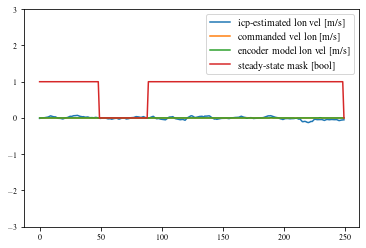

In [15]:
# plot single linear command step
cmd_step = 98
step_length = 250

for i in range(0, n_points):
    if calib_step[i] == cmd_step:
        plt.plot(icp_vels[i-step_length:i,0], label='icp-estimated lon vel [m/s]')
#         plt.plot(icp_vels[i-step_length:i,1], label='icp-estimated lat vel [m/s]')
        plt.plot(cmd_vx[i-step_length:i], label='commanded vel lon [m/s]')
        plt.plot(diff_drive_vels[i-step_length:i, 0], label='encoder model lon vel [m/s]')
        plt.plot(steady_state_mask[i-step_length:i], label='steady-state mask [bool]')
        plt.ylim(-3,3)
        plt.legend()
        print(i)
        break

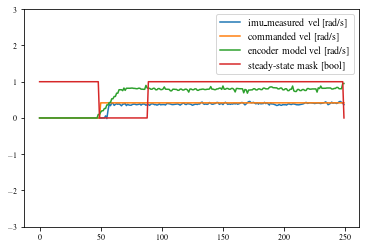

In [16]:
# plot single angular command step

for i in range(0, n_points):
    if calib_step[i] == cmd_step:
        plt.plot(imu_yaw[i-step_length:i], label='imu_measured vel [rad/s]')
        plt.plot(cmd_omega[i-step_length:i], label='commanded vel [rad/s]')
        plt.ylim(-3,3)
        plt.plot(diff_drive_vels[i-step_length:i, 2], label='encoder model vel [rad/s]')
        plt.plot(steady_state_mask[i-step_length:i], label='steady-state mask [bool]')
        plt.legend()
        break

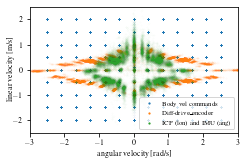

In [17]:
plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5), 
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = 0.05, 
#                   lw=0, 
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

alpha_plot = 0.01

cmd = ax.scatter(cmd_omega, cmd_vx, 
                  c = 'tab:blue', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=5,
                  label='Body vel commands',
                 rasterized=True)

encoder = ax.scatter(diff_drive_vels[:, 2], diff_drive_vels[:, 0], 
                  c = 'tab:orange', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=5,
                  label='Diff-drive_encoder',
                 rasterized=True)

icp = ax.scatter(imu_yaw, icp_vels[:, 0], 
                  c = 'tab:green', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=5,
                  label='ICP (lon) and IMU (ang)',
                 rasterized=True)

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-3, 3)
ax.set_ylim(-2.5, 2.5)

# ax.set_xticks([-1,0,1])
# ax.set_yticks([-1,0,1])
# ax.set_xticklabels([r'$-\dot{\theta}_{max}$', '0', r'$\dot{\theta}_{max}$'])
# ax.set_yticklabels([r'$-v_{max}$', '0', r'$v_{max}$'])

fig.subplots_adjust(left=.15, bottom=.17, right=.98, top=.98)
fig.set_size_inches(width, height)

plt.savefig('/home/dominic/repos/norlab_WMRD/DB/figs/husky_velocities_w_icp.jpg', dpi=500)

In [32]:
# concatenate all data, export full dataset

# print(timestamp.shape)
# print(icp_states.shape)
# print(imu_euler.shape)
# print(icp_states[:, 2:].shape)
# print(cmd_vx.shape)
# print(cmd_omega.shape)
# print(wheel_left_vel.shape)
# print(wheel_right_vel.shape)
# print(calib_step.shape)
# print(steady_state_mask.shape)

# print(icp_states[:, 2:])

parsed_dataset = np.concatenate((timestamp.reshape(n_points,1), imu_euler, cmd_vx.reshape(n_points,1), cmd_omega.reshape(n_points,1), icp_states[:, 2:],
                                 icp_vels, wheel_left_vel.reshape(n_points,1), wheel_right_vel.reshape(n_points,1), diff_drive_vels,
                                 calib_step.reshape(n_points,1), steady_state_mask.reshape(n_points,1)), axis=1)

cols = ['timestamp', 'imu_roll_vel', 'imu_pitch_vel', 'imu_yaw_vel', 'cmd_vx', 'cmd_omega', 
        'icp_x', 'icp_y', 'icp_yaw', 'icp_vx', 'icp_vy', 'icp_omega',
        'wheel_left_vel', 'wheel_right_vel', 'diff_drive_vels_x', 'diff_drive_vels_y', 'diff_drive_vels_omega', 
        'calib_step', 'steady_state_mask']

parsed_dataset_df = pd.DataFrame(parsed_dataset, columns = cols)
parsed_dataset_df.to_pickle('/home/dominic/repos/norlab_WMRD/data/husky/parsed_data/grass_1_full.csv')

## Only plot one scatter (median) per step
## Plot std_dev for each step
## Prepeare denser sampling in smaller velocities
print(steady_state_mask)
print(parsed_dataset)

[False False False ... False False False]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.64559360e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.06417152e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.36455021e+03 -1.58772327e-03 -2.17444520e-03 ...  0.00000000e+00
   2.15000000e+02  0.00000000e+00]
 [ 2.36460659e+03 -2.52946652e-03 -1.21221377e-03 ...  0.00000000e+00
   2.15000000e+02  0.00000000e+00]
 [ 2.36465676e+03 -4.30291693e-04 -2.22622720e-03 ...  0.00000000e+00
   2.15000000e+02  0.00000000e+00]]


In [87]:
# loop through dataset, find all horizons

parsed_dataset_steady_state = parsed_dataset[steady_state_mask]
n_points_steady_state = parsed_dataset_steady_state.shape[0]

training_horizon = 2

horizon_starts = []
horizon_ends = []

for i in range(1, n_points_steady_state):
    if parsed_dataset_steady_state[i-1, 17] != parsed_dataset_steady_state[i, 17]:
        horizon_starts.append(i)
        horizon_elapsed = 0
        j = i
        if parsed_dataset_steady_state[j, 17] == parsed_dataset_steady_state[-1, 17]:
            horizon_starts.pop()
            break
        while parsed_dataset_steady_state[j+1, 17] == parsed_dataset_steady_state[j, 17]:
            horizon_elapsed += (parsed_dataset[j+1, 0] - parsed_dataset[j, 0])
            if horizon_elapsed >= 2.0:
                horizon_ends.append(j)
                horizon_starts.append(j+1)
                horizon_elapsed = 0
            j += 1
        horizon_starts.pop()

print(len(horizon_starts))
print(len(horizon_ends))

print(horizon_starts[638])
print(horizon_ends[638])
    

639
639
34160
34200


In [96]:
# build torch-ready dataset

rate = 0.05
timesteps_per_horizon = int(training_horizon / rate)

torch_input_array = np.zeros((len(horizon_starts), 3+timesteps_per_horizon*2)) # [icp_x, icp_y, icp_yaw, vx0, vomega0, vx1, vomega1, vx2, vomega2, vx3, vomega3]
torch_output_array = np.zeros((len(horizon_starts), 3)) # [icp_x, icp_y, icp_yaw]



for i in range(0, len(horizon_starts)):
    horizon_start = horizon_starts[i]
    torch_input_array[i, :3] = parsed_dataset_steady_state[horizon_start, 6:9]
    for j in range(0, timesteps_per_horizon):
        torch_input_array[i, 3+j*2:3+j*2+2] = parsed_dataset_steady_state[horizon_start+j, 4:6]
    torch_output_array[i, :] = parsed_dataset_steady_state[horizon_ends[i], 6:9]
    
torch_array = np.concatenate((torch_input_array, torch_output_array), axis=1)

cols = ['init_icp_x', 'init_icp_y', 'init_icp_yaw']
for i in range(0, timesteps_per_horizon):
    str_cmd_vx_i = 'cmd_vx_' + str(i)
    str_cmd_omega_i = 'cmd_omega_' + str(i)
    cols.append(str_cmd_vx_i)
    cols.append(str_cmd_omega_i)
cols.append('gt_icp_x')
cols.append('gt_icp_y')
cols.append('gt_icp_yaw')

torch_dataset_df = pd.DataFrame(torch_array, columns = cols)
torch_dataset_df.to_pickle('/home/dominic/repos/norlab_WMRD/data/husky/parsed_data/grass_1_torch.csv')

print(torch_dataset_df)

     init_icp_x  init_icp_y  init_icp_yaw  cmd_vx_0  cmd_omega_0  cmd_vx_1  \
0      1.012477   15.459271     -1.366977      -2.0     0.416667      -2.0   
1      0.470085   16.733973     -0.980306      -2.0     0.416667      -2.0   
2     -0.525775   17.687853     -0.578643      -2.0     0.416667      -2.0   
3     -3.952225   17.789022      0.720821      -2.0     0.833333      -2.0   
4     -4.462355   16.993017      1.361707      -2.0     0.833333      -2.0   
..          ...         ...           ...       ...          ...       ...   
634  -18.067970   23.864222     -0.803319       2.0    -1.666667       2.0   
635  -18.009340   23.414803     -1.699874       2.0    -1.666667       2.0   
636  -17.307983   28.173689      0.385637       2.0    -1.250000       2.0   
637  -16.765856   28.187654     -0.195229       2.0    -1.250000       2.0   
638  -16.205238   27.868204     -0.793489       2.0    -1.250000       2.0   

     cmd_omega_1  cmd_vx_2  cmd_omega_2  cmd_vx_3  ...  cmd_ome